# Predicting Euclid NISP-H Data with a cGAN
One of the most exciting applications of deep learning is image-to-image translation which includes tasks such as image segmentation, image colourisation and super resolution. This task needed a lot of human input and hardcoding several years ago but, with the development of deep learning over recent years, the whole process can be done end-to-end with the power of machine learning.

Here, we focus on predicting NISP-H band Euclid ERO data of the Perseus cluster (from $1.54\mu m$ to $2.00\mu m$) in the form of $20\times20$" cutouts given the Euclid VIS-band and NISP-Y and NISP-J bands as input to the network. The network we use is a *conditional Generative Adversarial Network* and the architecture closely follows that of [_**Image-to-Image Translation with Conditional Adversarial Networks**_](https://arxiv.org/abs/1611.07004), which may also be known as *pix2pix*, where a general solution to many image-to-image translation problems is proposed. 

The cGAN is trained on cutouts from the Perseus cluster that do *not* contain a simulated strong gravitational lens. The test set, however, conatins 500 gravitational lenses which are simulated in the *Lens_Simulation.ipynb*, and the goal is for the cGAN to find these lenses by the method of anomaly detection. 



### The World of cGANs
The architecture used in this problem is a conditional GAN which uses two losses, namely an $l1$ loss, which makes this task a regression task, and an adversarial (GAN) loss, which helps to solve this problem in an unsupervised manner. In a GAN, there is a Generator model and a Discriminator model which work together to solve a problem. In this model, the Generator tasks a 3-channel input, composed of the stacked Euclid VIS-band and NISP-Y and -J band data, and generates a 1-channel output, the NISP-H band data. The Discriminator takes the generated NISP-H band data and decides whether or not it is real- from the training set- or fake- from the generator. The condition is such that the Discriminator needs to see real inputs- those not produced by the Generator- and should learn that they are real.

The condition on this model is that both the Generator and Discriminator *see* real inputs.
Let's take a further look into what the cGAN is doing. Consider $x$ to be the input to the network, $z$ as some input noise to the Generator, and $y$ the output we expect from the Generator. Let $G$ and $D$ denote the Generator and Discriminator, respectively. The loss of the cGAN can be described via:
\begin{equation}
\mathcal{L}_{cGAN}(G,D)=\mathcal{E}_{x,y}[logD(x|y)]+\mathcal{E}_{z\approx P_{z}(z),y}[log(1-D(x,G(z|y)))].
\end{equation}
Note that $y$ is the condition we've introduced and it is seen by both $G$ and $D$. Also, note that we are not feeding an $n$-dimensional vector of random noise to the Generator, which is common in GANs. Here, noise is introduced in the form of dropout layers in the Generator network. 

The goal is optimisation and, more specifically, to minimise the loss. Equation $\mathcal{L}_{cGAN}(G,D)$ helps to produce an output that seems real, however, to further steer the model in the right direction and to introduce some supervision into this task, we combine the above loss with the $l1$ loss/mean absolute error:
\begin{equation}\label{eq:l1}
\mathcal{L}_{L1}(G)=\sum_{i=1}^n ||y-G(x,z)||.
\end{equation}
The model will learn features from the data using the $L1$ loss alone, but it will be conservative and take an average which will reduce the $L1$ loss as much as possible. This can be compared to the blurring effect of $L1$ or $L2$ losses in super resolution tasks. Combining Equation $\mathcal{L}_{cGAN}(G,D)$ with Equation $\mathcal{L}_{L1}(G)$ gives the overall loss function, or a min-max game between the two models:
\begin{equation}\label{eq:minmax}
\mathcal{L}(G)=arg min_{G}max_{D}\mathcal{L}_{cGAN}(G,D)+\lambda\mathcal{L}_{L1}(G),
\end{equation}
where $\lambda$ is the coefficient to balance the contribution of the two losses to the final loss. Note that the Discriminator is not trained with the $L1$ loss.

The cGAN is implemented using PyTorch; a convenient package for machine learning models. This example uses $40,000$ training data samples in the form of the stacked VIS-band, NISP-Y and NISP-J bands of size $20\times20$" which corresponds to $100\times100$ pixels. You are welcome to train the network on your own data provided it is in the same format.

We will start by importing standard packages.

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
from astropy.io import fits
import warnings
import glob
from astropy.wcs import WCS

Get the path to YOUR training files and list the filters.

In [2]:
# path to YOUR working directory
home = "/Users/ruby/Documents/Python Scripts/Euclid-cGAN/DATASET/Data/"
mode = ['Train/', 'Val/', 'Test/']
ext = 'Dataset/'

# list of filters for Euclid
filters = ['NISP-H/', 'NISP-J/', 'NISP-Y/', 'VIS/']
nbands = len(filters)

The data that we extracted in the *Lens_Dataset.ipynb* must be normalised before feeding to the network. Since large pixel values will cause long training times, we normalise the data appropriately across all 4 filters. To do this, we make a histogram of each data file we extracted for each filter and take the lower and upper 10% percentiles.
*The following code block takes a long time to run...grab a coffee...*

In [4]:
# normalise the values of each fits file between the relevant waveband percentiles
def Bounds(path, phase, filtername):
    file_list = glob.glob(f"{path}/{phase}/{ext}/{filtername}/*.fits")
    values_lower, values_upper = [], []
    for i in file_list:
        with fits.open(i) as fitsfile:
            img = fitsfile[0].data
            lower, upper = img.min(), img.max()
            values_lower.append(lower)
            values_upper.append(upper)
    lower_bound = np.mean(np.array(values_lower))
    upper_bound = np.mean(np.array(values_upper))
    return lower_bound, upper_bound

# create a list to append the percentiles of each filter to
normalization = []
for filter_ in filters:
    lower, upper = Bounds(home, mode[0], filter_) # mode 0 for training
    normalization.append([lower, upper])
    
h_lower, h_upper = normalization[0][0], normalization[0][1]
j_lower, j_upper = normalization[1][0], normalization[1][1]
y_lower, y_upper = normalization[2][0], normalization[2][1]
vis_lower, vis_upper = normalizaton[3][0], normalization[3][1]

KeyboardInterrupt: 

Before creating the dataset and dataloaders, the training set needs to be normalised with the above percentiles. So, we define a simple Min-Max normalisation below.

In [3]:
def Normalise(data):
    return ((data - data.min())/ (data.max() - data.min()))

### Dataset and Dataloaders
Here, we create the dataset for the cGAN. First, the data must be transformed to the correct size for the model (which is $256\times256$). We do this since the network takes relatively small kernel sizes (of size $4\times4$) meaning that it has a small receptve field. Taking too large an input size will result in a narrow network which is difficult to train. Additionally, the layers within the U-Net are easier to design when the inputs are a factor of $2$ in size, thus, resizing the inputs to $256=2^8$ allows for easy construction of the convolution layers.

The data for each filter are read, appened as an input for the VIS-band and NISP-Y and -J bands (as a label for NISP-H band since it's the condition) and normalised using the above function. Both the inputs and labels are transformed to a tensor of shape [(channel, height, width)] before being resized to $256\times256$. We then create the dataloaders. 


In [4]:
SIZE = 256
# create the dataset for the fits files
class FilterDataset(Dataset):
    def __init__(self, path, split):
        ''' path = path to directory containing fits files '''
        self.path = path
        self.split = split
        self.transforms_inputs = torch.nn.Sequential(transforms.Resize((SIZE, SIZE)))
                                                     
        self.transforms_labels = torch.nn.Sequential(transforms.Resize((SIZE, SIZE)))
                                                    
        self.NISPh_path = path+split+'Dataset/NISP-H/'
        self.NISPj_path = path+split+'Dataset/NISP-J/'
        self.NISPy_path = path+split+'Dataset/NISP-Y/'
        self.VIS_path = path+split+'Dataset/VIS/'
        self.l1 = len(os.listdir(self.NISPh_path)) - 1 
    
    def __len__(self):
        # return total number of fits files for the galaxy cutouts consistent
        # with the 'idx' in the __getitem__ method
        return (self.l1)
    
    def __getitem__(self, idx):
        # get the name of the fits file
        name = str(idx)+'.fits'
        # for each input filter, get each fits file, open and extract the 
        # first row (only row which is 'SCI' data) and normalise before
        # formatting into an array
        hdu1 = fits.open(self.NISPj_path+name)[0]
        data1 = np.array(Normalise(hdu1.data))
        hdu2 = fits.open(self.NISPy_path+name)[0]
        data2 = np.array(Normalise(hdu2.data))
        hdu3 = fits.open(self.VIS_path+name)[0]
        data3 = np.array(Normalise(hdu3.data))
        # now the same for the label filters as    
        hdu4 = fits.open(self.NISPh_path+name)[0]
        data4 = np.array(Normalise(hdu4.data))

        
        # stack the input filters (VIS, NISP-Y, NISP-J)
        inputs = np.dstack((data1, data2, data3)).astype("float32")
        # reformat the inputs as tensors
        inputs = transforms.ToTensor()(inputs)
        # reshape the tensor to [C, H, W] for the transform to work
        inputs = inputs.permute(0, 1, 2)
        # now resize the inputs to 256x256
        inputs = self.transforms_inputs(inputs)
        
        # do the same for the labels- NISP-H
        labels = np.dstack((data4, data4, data4)).astype("float32")
        labels = transforms.ToTensor()(labels)
        labels = labels.permute(0, 1, 2)
        labels = self.transforms_labels(labels)
        
        # return the inputs with corresponding labels in a dictionary
        return {'Inputs': inputs, 'Labels': labels}

Now, we create the dataloaders.

In [5]:
def Make_Dataloaders(path, split, batch_size):
    if split == 'Train/':
        dataset = FilterDataset(path=home, split=split)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    elif split == 'Val/':
        dataset = FilterDataset(path=home, split=split)
        # do not shuffle the validation set
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    elif split == 'Test/':
        dataset = FilterDataset(path=home, split=split)
        # do not shuffle the test set 
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader

trainloader = Make_Dataloaders(path=home, split='Train/', batch_size=16)
valloader = Make_Dataloaders(path=home, split='Val/', batch_size=16)
testloader = Make_Dataloaders(path=home, split='Test/', batch_size=16)

Okay, let's make some checks and see an example input and label!

In [6]:
data = next(iter(trainloader))
inputs_, labels_ = data['Inputs'], data['Labels']

In [7]:
print(inputs_.shape, labels_.shape)

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


In [8]:
print(len(trainloader))

1663


Let's plot an input and a label.

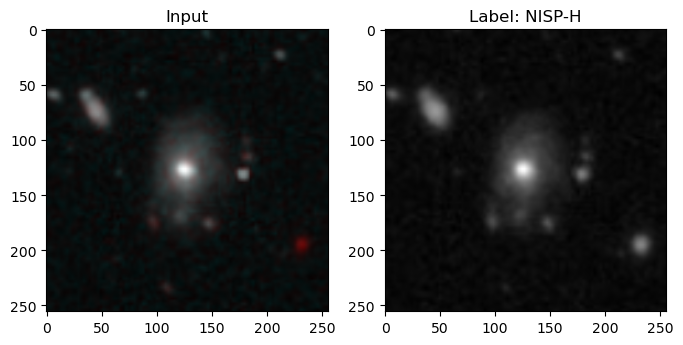

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))
input_img = inputs_[0].numpy().transpose(2,1,0)
label_img = labels_[0].numpy().transpose(2,1,0)
ax1.imshow(input_img)
ax1.set_title("Input")
ax2.imshow(label_img, cmap='gray')
ax2.set_title("Label: NISP-H")
plt.show()

Looks great!


### Generator Architecture
The following code implements the U-Net to be used as the Generator for the cGAN. It produces the U-Net from the middle part, down in the U shape, and adds down-sampling and up-sampling modules to the left and the right of the middle module, respectively, at every iteration until it reaches the input module and output module shown below:
![U-Net](images/U-Net.png).
The blue boxes show the order in which the related modules are built. The U-Net in the following code has more layers than depicted above.
In what follows, we go 8 layers down, so, starting with a $256\times256$ input, we down-sample to a $1\times1$ ($256/2^8$) tensor in the middle of the U-Net which then gets up-sampled to produce a tensor of size $256\times256$ again.

In [11]:
# Generator as proposed by the pix2pix image translation paper
class UNetBlock(nn.Module):
    ''' U-Net is used as the generator of the GAN.
        Creates the U-Net from the middle part down and adds down-sampling and
        up-sampling modules to the left and right of the middle module.
        8 layers down so start with a 256x256 tensor with 3 channels, down-sample 
        to a 1x1 tensor, then up-sample to a 256x256 tensor with 1 channel. '''
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        ''' ni = number of filters in the inner convolution layer
            nf = number of filters in the outer convolution layer
            input_c = number of input channels (= 3)
            submodule = previously defined submodules
            dropout = not using dropout layers '''
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(in_channels=input_c, out_channels=ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost: # if this module is the outermost module i.e downsampling
            upconv = nn.ConvTranspose2d(in_channels=ni*2, out_channels=nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost: # if this module is the innermost module, i.e upsampling
            upconv = nn.ConvTranspose2d(in_channels=ni, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(in_channels=ni*2, out_channels=nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else: # add skip connections
            return torch.cat([x, self.model(x)], dim=1)

In [12]:
class UNet(nn.Module):
    ''' U-Net based generator.'''
    def __init__(self, input_c=3, output_c=3, n_down=8, num_filters=64):
        ''' input_c = number of input channels (= 3)
            output_c = number of output channels (= 1)
            n_down = number of downsamples: we start with 256x256 and after 
                                            8 layers, we have a 1x1 tensor at the bottleneck.
            num_filters = number of filters in the last convolution layer. '''
        super().__init__()
        unet_block = UNetBlock(num_filters*8, num_filters*8, innermost=True)
        for _ in range(n_down - 5):
            # adds intermediate layers with num_filters * 8 filters
            unet_block = UNetBlock(num_filters*8, num_filters*8, submodule=unet_block, dropout=True)
        out_filters = num_filters*8
        for _ in range(3):
            # gradually reduce the number of filters to num_filters
            unet_block = UNetBlock(out_filters//2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UNetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

### Discriminator Architecture
The following code describes the architecture of the Discriminator which implements a model by stacking blocks of Convolution-Batch Normalisation-Leaky ReLU to decibe whether an input tensor is real or fake. The first and last blocks do *not* use batch normalisation and the last block has *no* activation function (since the activation function will be embedded in the loss function we will use later).

In [13]:
class PatchDiscriminator(nn.Module):
    ''' Patch discriminator stacks blocks of convolution-batchnorm-leakyrelu 
        to decide whether the input tensor is real or fake. 
        Patch discriminator outputs one number for every NxN pixels of the input
        and decides whether each "patch" is real/fake. 
        Patches will be 70 by 70. '''
    def __init__(self, input_c, num_filters=64, n_down=3):
        ''' input_c = number of input channels (= 3)
            num_filters = number of filters in last convolution layer
            n_down = number of layers '''
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        # use if statement to take care of not using a stride of 2 in the last block of the loop
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i+1), s=1 if i == (n_down-1) else 2) for i in range(n_down)]
        # do not use normalisation or activation for the last layer of the model
        model += [self.get_layers(num_filters * 2 ** n_down, 3, s=1, norm=False, act=False)] 
        self.model = nn.Sequential(*model)
    
    # make a separate method for the repetitive layers
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        ''' norm = batch norm layer
        act = apply activation '''
        layers = [nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=k, stride=s, padding=p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x) 

Let's take a look at its blocks...

In [15]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

...and the shape of its output.

In [17]:
discriminator = PatchDiscriminator(3)
input_ = torch.randn(16, 3, 256, 256) # dummy input of size [(batch, channels, height, width)]
output = discriminator(input_)
print(output.shape)

torch.Size([16, 3, 30, 30])


Why is the output size (height, width)$=(30,30)$? 

That's because we are using a *Patch Discriminator*.
In a vanilla discriminator, the model outputs one number (a scalar), which represents how much the model thinks the input tensor is real (or fake). In a patch discriminator, however, the model outputs one number for every patch of say ~$70\times70$ pixels of the input tensor, and for each of them, decides whether it is real (or fake), separately. Using such a model for this task is reasonable because the local changes that the model needs to make are important. Making a decision on the whole input tensor regarding whether it is real or fake, such as in a vanilla discriminator, cannot take care of the subtleties of this task.

Here, the output shape is $30\times30$, but that does not mean that the patches are of size $30\times30$. The actual patch size is obtained when we compute the [_**receptive field**_](https://www.researchgate.net/figure/The-PatchGAN-discriminator-where-the-receptive-field-of-the-discriminator-is-N-N-Gz_fig5_336431839) of each of these 900 ($30\times30=900$) output numbers, which will be 70 by 70 in this case.

### GAN Loss
We need to initiate the adversarial GAN loss for the final model. Below,in the **init** function, we decide what type of loss we will use andwe register some constant tensors as the "real" and "fake" labels, representing a tensor of all 1's or all 0's, respectively. It fills these tensors when. we call the module and it computes the loss.

In [19]:
# Unique loss function for the GAN 
class GANLoss(nn.Module):
    ''' Calculates the GAN loss of the final model.
        Uses a "vanilla" loss and registers constant tensors for the real
        and fake labels. Returns tensors full of zeros or ones to compute the loss'''
        
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer(name='real_label', tensor=torch.tensor(real_label))
        self.register_buffer(name='fake_label', tensor=torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss() # binary cross entropy loss
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss() # don't use this
        
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds) # expand to the same size as predictions
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### Model Initialisation
Here, we initialise the weights of the model with a mean, $\mu=0$, and a standard deviation, $\sigma=0.02$. We also initialise the entire model by sending the model to the device (I use "mps" since I'm working with a Mac, so you'll need to use "cuda" for an intel machine) and initialising its weights.

In [20]:
# Initilise the weights of the model here
def Init_Weights(net, init='norm', gain=.02):
    ''' Image-to-image translation paper state that the model is initialised 
        with a mean of 0.0 and std 0.02'''
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                # fills tensor with values drawn from normal distribution N(mean,std^2)
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier': 
                # fills input tensor with avlues sampled from N(0,std^2)
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming': 
                # resulting tensor has values sampled from N(0,std^2)
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(tensor=m.bias.data, val=0.0) # tensor filled with zeros
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(tensor=m.bias.data, val=0.0)
    
    net.apply(init_func)
    print(f"model initialised with {init} initialisation")
    return net

def Init_Model(model, device):
    model = model.to(device)
    model = Init_Weights(model)
    return model

### The Model
The following code is a class that brings all the previous sections together and implements the methods required to train the model.

Firstly, in the **init** function, we define the Generator and Discriminator networks using the above classes that we defined and we initialise them using the **Init_Model** function above. We define the two loss functions that we have discussed and the optimisers of both the Generator and Discriminator. This is the [_**Adam**_](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimiser which is similar to applying stochastic gradient descent. It is also worth notin the learning rate of both the Generator and Discriminator, which have a learning rate of $lr_G=lr_D=0.0002$. This learning rate is carefully selected; a learning rate that is too large might lead to a divergent solution, and a learning rate that is too small will take unnecessarily long to train and eventually end up in a local minimum. This learning rate proves sufficient.

The majority of computations are done in the **optimise** method of this class. First, and only once per iteration (per batch of training), we call the module's forward method and store the outputs in the *fake_fits* variable of the class.

The Discriminator is trained first using the **backward_D** method, where we feed the *fake* samples produced by the Generator (we detach them from the Generator's graph to ensure that they act as a constant to the Discriminator) and we label the samples as *fake*. A batch of *real* samples from the training data is then fed to the Discriminator and labelled as *real*. The losses for the *fake* and *real* data is calculated and added together, the average between the two taken, and the backward method called on the final loss. The Generator is then trained. In the **backward_G** method, the Discriminator is fed the *fake* samples and we try to fool the Discriminator by assigning *real* labels and calculating the adversarial (GAN) loss. as previously mentioned, the $L1$ loss is also used to compute the distance between the predicted output and the target output, which is then multiplied by the coefficient $\lambda$ (where we are using $\lambda=100$) to balance the two losses before adding this loss to the adversarial loss.

The backward method is then finally called.

In [21]:
# now to initialise the main GAN network
class GANModel(nn.Module):
    ''' Initialises the model defining the generator and discriminator in the
        __init__ function using the functions given and initialises the loss
        functions '''
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=.5, beta2=.999, lambda_L1=100.): 
        super().__init__()
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = Init_Model(UNet(input_c=3, output_c=3, n_down=8, num_filters=64), self.device)
        else:
            self.net_G.to(self.device)
        
        self.net_D = Init_Model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GAN_loss = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1_loss = nn.L1Loss()
        # initialise optimisers for generator and discriminator  
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1,beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1,beta2))
        # initialise empty lists to append the generator and discriminator losses to
        self.generator_losses, self.discriminator_losses = [], []
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        # Get the input data and labels
        self.inputs = data['Inputs'].to(self.device)
        self.labels = data['Labels'].to(self.device)
    
    def forward(self):
        # For each batch in the training set, forward method is called and
        # outputs stored in fake_fits variable
        self.fake_fits = self.net_G(self.inputs)
        
    def backward_D(self):
        ''' Discriminator loss takes both target and input images.
            loss_D_real is sigmoid cross-entropy loss of the target tensors and an array
            of ones. 
            loss_D_fake is sigmoid cross-entropy loss of the input tensors and an
            array of zeros.
            Discriminator loss is loss_D = loss_D_real + loss_D_fake. '''
        # Train the discriminator by feeding the fake images produced by the 
        # generator 
        fake_fits = self.fake_fits
        fake_preds = self.net_D(fake_fits.detach()) # detach from generator's graph so they act like constants
        # label the fake images as fake 
        self.loss_D_fake = self.GAN_loss(preds=fake_preds, target_is_real=False)
        # Now feed a batch of real images from the training set and label them as real
        real_fits = self.labels
        real_preds = self.net_D(real_fits)
        self.loss_D_real = self.GAN_loss(preds=real_preds, target_is_real=True)
        # Add the two losses for fake and real, take the average and call backward()
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * .5
        self.loss_D.backward()
        self.discriminator_losses += [self.loss_D.item()]
    
    def backward_G(self):
        ''' Generator loss is a sigmoid cross-entropy of input tensors and an 
            array of ones. Using the L1 loss, input tensors are structurally
            similar to the target tensors.
            Generator loss is defined as loss_G = loss_G_GAN + loss_G_L1*lambda_L1. '''
        # Train the generator by feeding the discriminator the fake fits data and 
        # fool it by assigning real labels and calculating adversarial loss.
        fake_fits = self.fake_fits
        fake_preds = self.net_D(fake_fits.detach())
        self.loss_G_GAN = self.GAN_loss(preds=fake_preds, target_is_real=True)
        # Use L1 loss so tensors are not averaged over and compute the 
        # difference between the prediction and real and multiply 
        # by constant lambda 
        self.loss_G_L1 = self.L1_loss(self.fake_fits, self.labels) * self.lambda_L1
        # Add L1 loss to the adversarial loss then call backward()
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
        self.generator_losses += [self.loss_G_GAN.item()]
        
    def optimise(self):
        # Now optimise by the usual method of zeroing the gradients and calling
        # step() on the optimiser
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### Helper Functions
Below are the functions used to help visualise how the losses of the model are updated and to illustrate the performance of the model. The losses are logged and the results are shown with the help of these functions after each epoch.

In [22]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count
        
def Create_Loss_Meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

# Update losses after each epoch
def Update_Losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
    return loss_meter 

# Plot the losses for both the Generator and Discriminator
def Loss_Plot(model, save=False):
    gen_loss = model.generator_losses
    dis_loss = model.discriminator_losses
    fig = plt.figure(figsize=(12,6))
    plt.plot(gen_loss, label='Generator Loss', color='red')
    plt.plot(dis_loss, label='Discriminator Loss', color='blue', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    if save:
        fig.savefig(f"loss_{time.time()}.png")

Also of use are functions which plot the results. The following functions plot the output of the cGAN as opposed to the true label (ground truth NISP-H band data) along with the input (VIS-band and NISP-Y and NISP-J bands).

In [23]:
def Visualise_Train(model, data, save=False):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_fits = model.fake_fits.detach()
    fake_fits /= torch.max(fake_fits)
    real_fits = model.labels
    real_fits /= torch.max(real_fits)
    inputs = model.inputs
    inputs /= torch.max(inputs)
    inputs = inputs.permute(0, 3, 2, 1).cpu().numpy()
    fake_fits = fake_fits.permute(0, 3, 2, 1).cpu().numpy()
    real_fits = real_fits.permute(0, 3, 2, 1).cpu().numpy()
    fig = plt.figure(figsize=(9,11))
    for i in range(2):
        ax = plt.subplot(3, 2, i+1)
        try:
            ax.imshow(inputs[i])
            ax.set_title(r"VIS+NISP-YJ [$0.55-1.54\mu$m]")
            ax.axis("off")
        except IndexError:
            continue
        ax = plt.subplot(3, 2, i+1+2)
        ax.imshow(fake_fits[i])
        ax.set_title("Generated NISP-H")
        ax.axis("off")
        ax = plt.subplot(3, 2, i+1+4)
        ax.imshow(real_fits[i])
        ax.set_title(r"Actual NISP-H [$1.54-2.00\mu$m]")
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    if save:
        fig.savefig("train.png")

# different function for testing
def Visualise_Test(model, data, save=False):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.eval()
    fake_fits = model.fake_fits.detach()
    fake_fits /= torch.max(fake_fits)
    real_fits = model.labels
    inputs = model.inputs
    inputs /= torch.max(inputs)
    inputs = inputs.permute(0, 3, 2, 1).cpu().numpy()
    fake_fits = fake_fits.permute(0, 3, 2, 1).cpu().numpy()
    real_fits = real_fits.permute(0, 3, 2, 1).cpu().numpy()
    real_fits /= torch.max(real_fits)
    fig = plt.figure(figsize=(9,11))
    for i in range(2):
        ax = plt.subplot(3, 2, i+1)
        try:
            ax.imshow(inputs[i])
            ax.set_title(r"VIS+NISP-YJ [$0.55-1.54\mu$m]")
            ax.axis("off")
        except IndexError:
            continue
        ax = plt.subplot(3, 2, i+1+2)
        ax.imshow(fake_fits[i])
        ax.set_title("Generated NISP-H")
        ax.axis("off")
        ax = plt.subplot(3, 2, i+1+4)
        ax.imshow(real_fits[i])
        ax.set_title(r"Actual NISP-H [$1.54-2.00\mu$m]")
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig("test.png")

### Model Parameters
Before we train, it's often useful to know how many learnable parameters a machine learning model has. *Parameters* in machine learning and deep learning are the values that the model can change independently as it learns. So, the number of learnable parameters are referring to the weights that are updated at each epoch.

In [24]:
# define a function to know the quantity of parameters in the model
def count_params(model):
    '''
    Count the total number of trainable parameters in a PyTorch model.

    Parameters
    ----------
    model : (nn.Module)
        The PyTorch model to count the parameters of.

    Returns
    -------
    num_params (int): The total number of trainable parameters the model has.

    '''
    # count the number of parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # we expect millions of parameters so convert this to orders of a million
    num_params = num_params/1e6
    
    print(f'The model has {num_params:.2f}M trainable parameters')
    
    return num_params

### Training Function
The functions below train and (test) the network, respectively, feeding data from the training set and (test set) for the network to learn features from. Here, we set the number of epochs for training. Training with 100 epochs is a recommendation, though, we do see results after around 40 epochs. After each epoch, the weights are tuned further to the optimal weight for better model performance.

Also defined is a function to log the losses.

In [25]:
# log the loss results
def Log_Results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")
        
# now train the network, display epochs and losses
def Train_Model(model, trainloader, epochs, display_every=30):
    print("Starting training....")
    start = time.time()
    data = next(iter(trainloader)) # batch for visualising the model output after fixed intervals after training
    for e in range(epochs):
        # function returning a dictionary of objects to log the losses of the complete network
        loss_meter_dict = Create_Loss_Meters() 
        i = 0
        for data in tqdm(trainloader):
            model.setup_input(data)
            model.optimise()
            Update_Losses(model, loss_meter_dict, count=data['Inputs'].size(0)) # updates the log objects
            i += 1
        print(f"\nEpoch {e+1}/{epochs}")
        if i % display_every == 0: 
            print(f"Iteration {i}/{len(trainloader)}")
        total_loss = Log_Results(loss_meter_dict) # function prints out the losses
        print(total_loss)
    Loss_Plot(model, save=False)
    Visualise_Train(model, data)
    endtime = time.time()
    end = endtime - start
    print("Time to train network: {:.2f}s".format(end))

def Test_Model(model, testloader, epochs, display_every=30):
    print("Testing...")
    data = next(iter(testloader))
    for epoch in range(epochs):
        loss_meter_dict = Create_Loss_Meters()
        counter = 0
        for data in tqdm(testloader):
            model.setup_input(data)
            model.optimise()
            Update_Losses(model, loss_meter_dict, count=data['Inputs'].size(0))
            counter += 1
        print(f"\nEpoch {epoch+1}/{epochs}")
        if counter % display_every == 0:
            print(f"Iteration {counter}/{len(testloader)}")
        total_loss = Log_Results(loss_meter_dict)
        print(total_loss)
    Loss_Plot(model, save=False)
    Visualise_Test(model, data)
    print("Finished testing")

Each epoch takes around 30 minutes of GPU runtime for 40,000 cutouts.
cGANs have a benefit of not requiring such large datasets, so, with a training set of roughly 2000 items, you will see good results and each epoch should take no longer than 4 minutes.

In [26]:
model = GANModel()


model initialised with norm initialisation
model initialised with norm initialisation


Let's count the parameters.

In [27]:
count_params(model)

The model has 57.20M trainable parameters


57.195974

In [28]:
# run this line if you wish to train
#Train_Model(model, trainloader, epochs=100)

We can save the best performing weights of the model for later use.

In [29]:
# save the model
weights_folder = '/Users/ruby/Documents/Python Scripts/Euclid-cGAN/Model' # YOUR path
model_path = os.path.join(weights_folder, 'cGAN.pth')
#torch.save(model.state_dict(), model_path)

# Results
### Results after Training
After training for 100 epochs, we do indeed get good results. By calling the *Visualise_Train()* function, we can plot the results after training.
![train](images/Results_Train.png)

Here, we see in the first row the VIS-band and NISP-Y and -J bands input to the cGAN, the middle row shows the cGAN's prediction compared to the true label for the NISP-H band data on the bottom row. We can see that we are clearly predicting that band to a high accuracy. But what we're more interested in is how the cGAN will predict on simulated lenses and whether or not it can find these lensing systems.

### Results after Testing
Though not shown in this notebook (although the relevant paths and functions have been stated to use to test the model), we want to test the cGAN against a test set that contains simulated strong gravitational lenses. Please refer to *Lens_Simulation.ipynb* to see how the lenses have been simulated.
The testloader above does load in our test set which contains 4500 non-lenses and 500 lenses. The reason for only using 500 lenses is that they are rare (roughly only 1 in 10,000 galaxies are lensed)so this number appreciates the true number of lenses. 

First, let's visualise an example from the testloader.

In [30]:
data_test = next(iter(testloader))
inputs_test, labels_test = data_test['Inputs'], data_test['Labels']
print(inputs_test.shape, labels_test.shape)

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


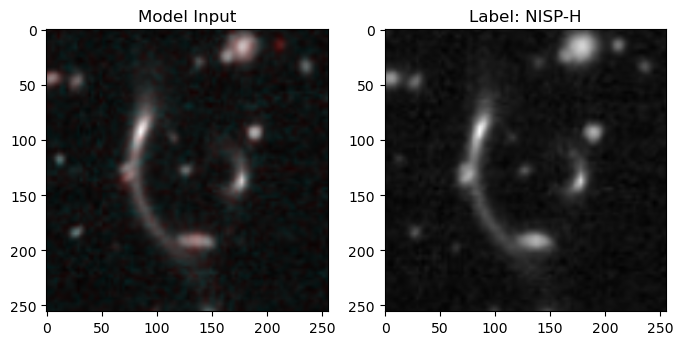

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
input_test = inputs_test[0].numpy().transpose(2,1,0)
label_test = labels_test[0].numpy().transpose(2,1,0)
ax1.imshow(input_test)
ax1.set_title("Model Input")
ax2.imshow(label_test, cmap='gray')
ax2.set_title("Label: NISP-H")
plt.show()

Will the model predict the image on the right given the image on the left?

The cGAN was put into evaulation mode and tested against the test set containing lenses that were previously unknown to the network. Results shown below.
![test](images/Results_test3.png)

Remember that the goal is lens finding through anomaly detection. We are not expecting good predictions on the lenses. We see that the cGAN's prediction is suffering on the simulated gravitational lenses- it's not producing a clear or sharp image and it's missing a lot of luminosity in the lensing features such as in the prominent arcs and rings. Again, our question is: can it *find* the lenses?

The answer is yes. A promising result shown below is the distribution of the cGAN's prediction for the test set in the form of a metric, $\mathcal{M}$. 
![distribution](images/Distribution_Results.png)

The metric is given by:
\begin{equation}
\mathcal{M}(y,\hat{y})= \frac{(\sum_{i=1}^n ||y-\hat{y}||)-\mu_1}{\mu_2-\mu_1},
\end{equation}
where $y$ and $\hat{y}$ are the true NISP-H band data and predicted NISP-H band data by the cGAN, respectively, and $(\mu_1,\mu_2)$ are the lower and upper percentiles of the NISP-H band.
There is a clear divide in results: one with a very low metric score and one with a higher metric score. Clearly, the lenses are not as well predicted by the cGAN and result in a higher metric score shown in red. Thus, we can say that using cGANs for anomaly detection as an alternative method of lens finding is a useful and interesting tool that we should not overlook.

Interestingly, in the above distribution, some lenses ($\approx 15$) were predicted rather well with a lower $\mathcal{M}$ score. These all turned out to be multiple image system that were rather faint or difficult to detect as a lensing system by eye. An example is shown below.
Could it be that the cGAN is responding to arcs and rings...*only*?

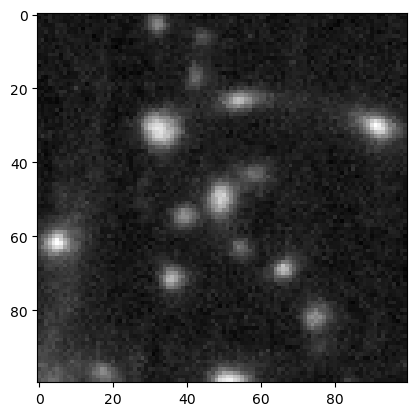

In [37]:
data_path = '/Users/ruby/Documents/Python Scripts/Euclid-cGAN/DATASET/Data/Files/NISP-H-out/'
hdu = fits.open(data_path+'34.fits')[0]
data_img = hdu.data
plt.imshow(data_img, cmap='gray')